In [142]:
import warnings
warnings.filterwarnings("ignore")

import os
import glob
import ddsp.training
from matplotlib import pyplot as plt
import IPython.display as ipd
import gin
import numpy as np
import utils
import tensorflow as tf

%matplotlib inline
sample_rate = 16000

## Set paths

### This DRIVE_DIR must includes your audio files

In [143]:
DRIVE_DIR = './Pretrained_ Models_for_T2/training_solo'  
assert os.path.exists(DRIVE_DIR)

In [144]:
# create all directories leading up to the given directory that do not exist already. 
# If the given directory already exists, ignore the error.
DATA_DIR = os.path.join(DRIVE_DIR, 'data')
!mkdir -p "$DATA_DIR"
AUDIO_DIR = os.path.join(DATA_DIR, 'audio')
AUDIO_FILEPATTERN = AUDIO_DIR + '/*'
!mkdir -p "$AUDIO_DIR"
# folder to save the model
SAVE_DIR = os.path.join(DRIVE_DIR, 'ddsp-solo-instrument')
!mkdir -p "$SAVE_DIR"

## Prepare Dataset


In [145]:
mp3_files = glob.glob(os.path.join(DRIVE_DIR, '*.mp3'))
wav_files = glob.glob(os.path.join(DRIVE_DIR, '*.wav'))
audio_files = mp3_files + wav_files

for fname in audio_files:
  target_name = os.path.join(AUDIO_DIR, 
                             os.path.basename(fname).replace(' ', '_'))
  print('Copying {} to {}'.format(fname, target_name))
  !cp "$fname" "$target_name"

Copying ./Pretrained_ Models_for_T2/training_solo/sax_1.wav to ./Pretrained_ Models_for_T2/training_solo/data/audio/sax_1.wav


In [146]:
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
!mkdir -p "$TRAIN_DIR"
TRAIN_TFRECORD = TRAIN_DIR + '/train.tfrecord'

!ddsp_prepare_tfrecord \
--input_audio_filepatterns="$AUDIO_FILEPATTERN "\
--output_tfrecord_path="$TRAIN_TFRECORD" \
--num_shards=10 \
--alsologtostderr

I0321 13:31:55.792752 4819926528 translations.py:641] ==================== <function annotate_downstream_side_inputs at 0x7f8d04867e50> ====================
I0321 13:31:55.796284 4819926528 translations.py:641] ==================== <function fix_side_input_pcoll_coders at 0x7f8d04867f70> ====================
I0321 13:31:55.805692 4819926528 translations.py:641] ==================== <function lift_combiners at 0x7f8d04868280> ====================
I0321 13:31:55.807311 4819926528 translations.py:641] ==================== <function expand_sdf at 0x7f8d04868430> ====================
I0321 13:31:55.807965 4819926528 translations.py:641] ==================== <function expand_gbk at 0x7f8d048684c0> ====================
I0321 13:31:55.811717 4819926528 translations.py:641] ==================== <function sink_flattens at 0x7f8d048685e0> ====================
I0321 13:31:55.812201 4819926528 translations.py:641] ==================== <function greedily_fuse at 0x7f8d04868670> ====================


In [148]:
data_provider = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN)
dataset = data_provider.get_dataset(shuffle=False)
PICKLE_FILE_PATH = os.path.join(SAVE_DIR, 'dataset_statistics.pkl')

utils.save_dataset_statistics(data_provider, PICKLE_FILE_PATH, batch_size=1)

Calculating dataset statistics for <ddsp.training.data.TFRecordProvider object at 0x7f949f217ac0>
Computing statistics for 57 examples.
Done! Saved to: ./Pretrained_ Models_for_T2/training_solo/ddsp-solo-instrument/dataset_statistics.pkl


Let's load the dataset in the `ddsp` library and have a look at one of the examples.

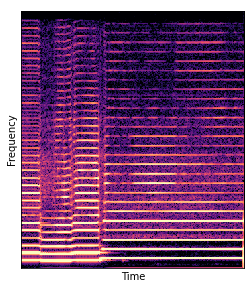

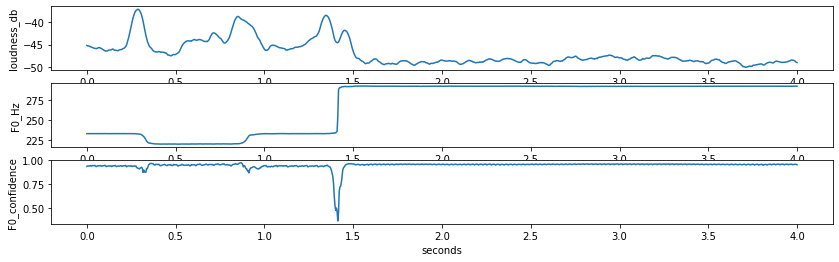

In [149]:
data_provider = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN)
dataset = data_provider.get_dataset(shuffle=False)

try:
  ex = next(iter(dataset))
except StopIteration:
  raise ValueError(
      'TFRecord contains no examples. Please try re-running the pipeline with '
      'different audio file(s).')

utils.specplot(ex['audio'])

f, ax = plt.subplots(3, 1, figsize=(14, 4))
x = np.linspace(0, 4.0, 1000)
ax[0].set_ylabel('loudness_db')
ax[0].plot(x, ex['loudness_db'])
ax[1].set_ylabel('F0_Hz')
ax[1].set_xlabel('seconds')
ax[1].plot(x, ex['f0_hz'])
ax[2].set_ylabel('F0_confidence')
ax[2].set_xlabel('seconds')
ax[2].plot(x, ex['f0_confidence'])


In [150]:
ipd.Audio(ex['audio'], rate = sample_rate)

## Train Model

We will now train a "solo instrument" model. This means the model is conditioned only on the fundamental frequency (f0) and loudness with no instrument ID or latent timbre feature. If you uploaded audio of multiple instruemnts, the neural network you train will attempt to model all timbres, but will likely associate certain timbres with different f0 and loudness conditions. 

In [151]:
%reload_ext tensorboard
import tensorboard as tb
tb.notebook.start('--logdir "{}"'.format(SAVE_DIR))

### We will now begin training. 

Note that we specify [gin configuration](https://github.com/google/gin-config) files for the both the model architecture ([solo_instrument.gin](TODO)) and the dataset ([tfrecord.gin](TODO)), which are both predefined in the library. You could also create your own. We then override some of the spefic params for `batch_size` (which is defined in in the model gin file) and the tfrecord path (which is defined in the dataset file). 

### Training Notes:
* Models typically perform well when the loss drops to the range of ~4.5-5.0.
* Depending on the dataset this can take anywhere from 5k-30k training steps usually.
* The default is set to 30k, but you can stop training at any time, and for timbre transfer, it's best to stop before the loss drops too far below ~5.0 to avoid overfitting.
* On the colab GPU, this can take from around 3-20 hours. 
* We **highly recommend** saving checkpoints directly to your drive account as colab will restart naturally after about 12 hours and you may lose all of your checkpoints.
* By default, checkpoints will be saved every 300 steps with a maximum of 10 checkpoints (at ~60MB/checkpoint this is ~600MB). Feel free to adjust these numbers depending on the frequency of saves you would like and space on your drive.
* If you're restarting a session and `DRIVE_DIR` points a directory that was previously used for training, training should resume at the last checkpoint.

In [147]:
TRAIN_TFRECORD_FILEPATTERN = TRAIN_DIR + '/train.tfrecord*'
print(TRAIN_TFRECORD_FILEPATTERN)

./Pretrained_ Models_for_T2/training_solo/data/train/train.tfrecord*
['./Pretrained_ Models_for_T2/training_solo/data/train/train.tfrecord-00001-of-00010', './Pretrained_ Models_for_T2/training_solo/data/train/train.tfrecord-00000-of-00010', './Pretrained_ Models_for_T2/training_solo/data/train/train.tfrecord-00006-of-00010', './Pretrained_ Models_for_T2/training_solo/data/train/train.tfrecord-00007-of-00010', './Pretrained_ Models_for_T2/training_solo/data/train/train.tfrecord-00008-of-00010', './Pretrained_ Models_for_T2/training_solo/data/train/train.tfrecord-00009-of-00010', './Pretrained_ Models_for_T2/training_solo/data/train/train.tfrecord-00002-of-00010', './Pretrained_ Models_for_T2/training_solo/data/train/train.tfrecord-00003-of-00010', './Pretrained_ Models_for_T2/training_solo/data/train/train.tfrecord-00005-of-00010', './Pretrained_ Models_for_T2/training_solo/data/train/train.tfrecord-00004-of-00010']


In [179]:
!ddsp_run \
  --mode=train \
  --alsologtostderr \
  --save_dir="$SAVE_DIR" \
  --gin_file=models/solo_instrument.gin \
  --gin_file=datasets/tfrecord.gin \
  --gin_param='FRecordProvider.file_pattern="$TRAIN_TFRECORD_FILEPATTERN"'\
  --gin_param="batch_size=16" \
  --gin_param="train_util.train.num_steps=10" \
  --gin_param="train_util.train.steps_per_save=2" \
  --gin_param="trainers.Trainer.checkpoints_to_keep=1"

I0321 13:55:20.572332 4714163712 ddsp_run.py:176] Restore Dir: ./Pretrained_ Models_for_T2/training_solo/ddsp-solo-instrument
I0321 13:55:20.572613 4714163712 ddsp_run.py:177] Save Dir: ./Pretrained_ Models_for_T2/training_solo/ddsp-solo-instrument
I0321 13:55:20.572848 4714163712 resource_reader.py:50] system_path_file_exists:optimization/base.gin
E0321 13:55:20.573075 4714163712 resource_reader.py:55] Path not found: optimization/base.gin
I0321 13:55:20.574287 4714163712 resource_reader.py:50] system_path_file_exists:eval/basic.gin
E0321 13:55:20.574455 4714163712 resource_reader.py:55] Path not found: eval/basic.gin
I0321 13:55:20.575600 4714163712 ddsp_run.py:147] Using operative config: ./Pretrained_ Models_for_T2/training_solo/ddsp-solo-instrument/operative_config-0.gin
I0321 13:55:20.582801 4714163712 resource_reader.py:50] system_path_file_exists:models/solo_instrument.gin
E0321 13:55:20.583064 4714163712 resource_reader.py:55] Path not found: models/solo_instrument.gin
I0321 1

I0321 13:55:38.816332 123145641046016 api.py:461] Output from Module: harmonic
Out: {'signal': [16, 64000], 'controls': {'amplitudes': [16, 1000, 1], 'harmonic_distribution': [16, 1000, 60], 'f0_hz': [16, 1000, 1]}}

I0321 13:55:38.825021 123145641046016 api.py:461] Input to Module: filtered_noise
Keys: ListWrapper(['noise_magnitudes'])
In: [[16, 1000, 65]]

I0321 13:55:38.938364 123145641046016 api.py:461] Output from Module: filtered_noise
Out: {'signal': [16, 64000], 'controls': {'magnitudes': [16, 1000, 65]}}

I0321 13:55:38.946002 123145641046016 api.py:461] Input to Module: add
Keys: ListWrapper(['filtered_noise/signal', 'harmonic/signal'])
In: [[16, 64000], [16, 64000]]

I0321 13:55:38.955785 123145641046016 api.py:461] Output from Module: add
Out: {'signal': [16, 64000], 'controls': {'signal_one': [16, 64000], 'signal_two': [16, 64000]}}

I0321 13:55:38.963361 123145641046016 api.py:461] Input to Module: reverb
Keys: ListWrapper(['add/signal'])
In: [[16, 64000]]

I0321 13:55:39

## Resynthesis

Check how well the model reconstructs the training data

Original Audio
Resynthesis


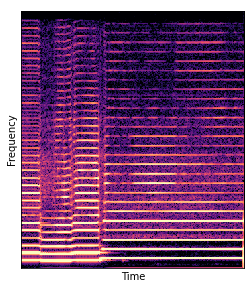

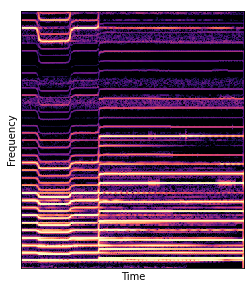

In [165]:
data_provider = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN)
dataset = data_provider.get_batch(batch_size=1, shuffle=False)

try:
  batch = next(iter(dataset))
except OutOfRangeError:
  raise ValueError(
      'TFRecord contains no examples. Please try re-running the pipeline with '
      'different audio file(s).')

# Parse the gin config.
gin_file = os.path.join(SAVE_DIR, 'operative_config-0.gin')
gin.parse_config_file(gin_file)

# Load model
model = ddsp.training.models.Autoencoder()
model.restore(SAVE_DIR)

# Resynthesize audio.
outputs = model(batch, training=False)
audio_gen = model.get_audio_from_outputs(outputs)
audio = batch['audio']

print('Original Audio')
utils.specplot(audio)

print('Resynthesis')
utils.specplot(audio_gen)

In [166]:
print('Original Audio')
ipd.Audio(audio[0], rate = sample_rate)

Original Audio


In [167]:
print('Resynthesis')
ipd.Audio(audio_gen[0], rate = sample_rate)

Resynthesis


## SAVE Checkpoint

Below you can download the final checkpoint. You are now ready to use it in the [DDSP Timbre Tranfer Colab](https://colab.research.google.com/github/magenta/ddsp/blob/master/ddsp/colab/demos/timbre_transfer.ipynb).

In [168]:
CHECKPOINT_ZIP = 'my_solo_instrument.zip'
latest_checkpoint_fname = os.path.basename(tf.train.latest_checkpoint(SAVE_DIR))
!cd "$SAVE_DIR" && zip $CHECKPOINT_ZIP $latest_checkpoint_fname* operative_config-0.gin dataset_statistics.pkl
!cp "$SAVE_DIR/$CHECKPOINT_ZIP" ./ #copy
# colab_utils.download(CHECKPOINT_ZIP)

  adding: ckpt-10.data-00000-of-00001 (deflated 6%)
  adding: ckpt-10.index (deflated 78%)
  adding: operative_config-0.gin (deflated 74%)
  adding: dataset_statistics.pkl (deflated 34%)
